In [1]:
import numpy as np
import scipy.integrate 
import matplotlib.pyplot as plt
import matplotlib.colors 
import tqdm

In [2]:
#define time interval, T should be integer
T = 5000

def mu(t):
    return 2/T * t - 1

def f(x,t): 
    return (x - x**3 /3.0 - mu(t))

In [3]:
def get_upper():
    n = T + 1
    ts = np.linspace(0,T,n)
    upper = np.zeros(n)

    for i in tqdm.trange(n):
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,50),[2.0])
        upper[i] = sol.y[0,-1]

    return ts, upper

In [71]:
ts, upper = get_upper()

100%|██████████| 5001/5001 [00:28<00:00, 178.05it/s]


In [74]:
#numerical simulation of SDEs:

steps_per_unit_time = 100                                           
solve_ts = np.linspace(0,T,T*steps_per_unit_time + 1)
dt = 1/steps_per_unit_time



#white noise case

xs_white = np.zeros(T*steps_per_unit_time + 1)
# xs_white[0] = 2.103803356099623
xs_white[0] = 2.07

sigma = 0.001
white_noise = np.random.normal(0,np.sqrt(dt),T*steps_per_unit_time)


for i in tqdm.trange(T*steps_per_unit_time):
    xs_white[i+1] = xs_white[i] + f(xs_white[i],solve_ts[i])*dt + sigma*white_noise[i]

wiener = np.zeros(T*steps_per_unit_time + 1)
wiener[0] = 2.07
for i in tqdm.trange(T*steps_per_unit_time):
    wiener[i+1] = wiener[i] + sigma*white_noise[i]


#red noise case

xs_red = np.zeros(T*steps_per_unit_time+1)
xs_red[0] = 2.103803356099623                                                           #upper[0]
kappa = 0                                                                    #shouldn't be too small 

def eta(theta):
    eta = np.zeros(T*steps_per_unit_time)
    for i in tqdm.trange(T*steps_per_unit_time - 1):
        eta[i+1] = np.exp(-theta*dt)*eta[i] + np.sqrt(1/(2*theta)*(1-np.exp(-2*theta*dt)))*np.random.normal(0,1)
    return eta

# eta = eta(1)


# for i in tqdm.trange(T*steps_per_unit_time):
#     xs_red[i+1] = xs_red[i] + f(xs_red[i],solve_ts[i])*dt + kappa*eta[i]*dt



xs_white_filtered = xs_white[::steps_per_unit_time]
# xs_red_filtered = xs_red[::steps_per_unit_time]


100%|██████████| 500000/500000 [00:00<00:00, 1254140.25it/s]


In [ ]:
plt.plot(solve_ts[:10000],xs_white[:10000], c = "blue")
plt.plot(solve_ts[:10000],wiener[:10000], c = "orange")

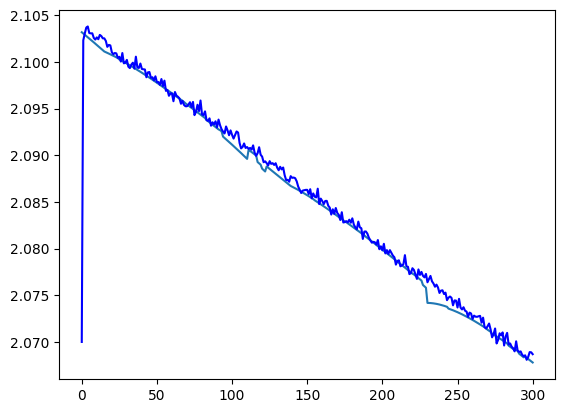

In [75]:

plt.plot(np.arange(301),upper[:301])
plt.plot(np.arange(301),xs_white_filtered[:301],color="blue")
# axs[0].plot(np.arange(301),xs_red_filtered[:301],color="red")